## Importing following libraries/modules
    1. NumPy - linear algebra
    2. Pandas - data processing, CSV file I/O (e.g. pd.read_csv)
    3. NLTK - Text processing and Sentiment Analysis
    4. SkLearn - Identifying the learning procedure - through ROC 
    5. Matplotlib - Visualization
    
#### Objective:
 Analyse the text of the tweets and develop sentiment analysis on tweets. The sentiment score is divided into **positive**, **negative** and **neutral** tone.
 
The task is completed by using two different techniques:
* **Naïve Bayes Classification**
* **Maximum Entropy**

Data is divided into 2 sets i.e. **TRAINING** and **TESTING** with **5000** and **10000** records, respectively. For training the model, we're spliting the **TRAINING** data into **TRAIN** and **VALIDATION** sets - with a split percentage of **90/10**.

In [1]:
import numpy as np  
import pandas as pd  
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from xml.sax.saxutils import escape, unescape
from sklearn.metrics import roc_curve, auc
import operator
import pdb
from difflib import SequenceMatcher

from Levenshtein import distance
from time import time

from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline

### Downloading NLTK Stopwords

We're using STOPWORDS provided by NLTK. STOPWORDs are removed in data cleaning process.

In [2]:
nltk.download('stopwords')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/dvlper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Loading
Reading the (.xlsx) file cotnaing **5000** data records. This data later converted into a **Pandas DataFrame**. Using a DataFrame allows various

In [3]:
# reading .xlsx file in a DataFrame
xl = pd.ExcelFile('Training Data.xlsx')
xl.sheet_names

# Excel file contains data in form of Sheets. Our file contains data in 'Sheet1'
data = xl.parse("Sheet1")

# removing unnecessary columns from the DataFrame
data.drop([u'ideas_id', u'user_id', u'permno'], axis=1, inplace=True)

### Train-validation Split

**5000** training examples are splited into train set with **4500** records and validation set containing **500** records. NOTE: while splitting the data, shuffling is set to True. Hence, the data in the trianing would contain samples from all the classes.

In [4]:
# Splitting the dataset into train and test set
train, validation = train_test_split(data, test_size = 0.1, random_state=22)

### Cleaning Data
Since, we're processing Tweets. Therefore the data is not already clean. So, we're setting up some cleaning procedures that are written only for Tweets in this type of dataset. Steps followed for cleaning:

    1. HTML Escape characters removed. While downloading the Tweets, some special characters would have been corupted and changed from ASCII to UNICODE. therefore, to correct this issue, we're unescaping tsuch charaters found in the Tweets.  
    
    2. Removing URLs from the Tweets. URLs do not convey any meaning in the Tweet. Instead, they affect the model negatively, by causing it to focus on ambigious text. Terefore, we removed all the URLs
    
    3. Trashed out words beggining with @, as such words are used for addressing an entity.
    
    4. Removed Dollar-Signs. In this particular these are used to indicate a stock market symbols (nicks). We avoid such words in text, as they do not convey any meaning to the overall sentiment.
    
    5. Furthermore, also removed HASHTAGS.

#### Once the text is clean and contains only English words. We now head to a text processing technique, to remove STOPWORDS. Using NLTK stopwords corpus for the purpose.

In [5]:
# Tweets contain HTML escape sequences and to be able to use the data for training, we need to remove
# these special characters
html_escape_table = {
     "&": "&amp;",
     '"': "&quot;",
     "'": "&apos;",
     ">": "&gt;",
     "<": "&lt;",
     }
# Reversing html_escape_table to make html_unescape_table
html_unescape_table = {v:k for k, v in html_escape_table.items()}

# function for removing the HTML escape characters from Tweets based on 'html_unescape_table'
def html_unescape(text):
    return unescape(text, html_unescape_table)

# Removing words that start with a contain a certain keyword.
def clean_row(row):
    words_filtered = [e.lower().replace('"', '').replace('(', '').replace(')', '') for e in html_unescape(row).split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('$') 
        and not word.startswith('#')]
    
    # Removing the stopwords and generating tokens from the Tweets
    words_without_stopwords = [wordnet_lemmatizer.lemmatize(word) for word in words_cleaned if not word in stopwords_set]
    
    return words_without_stopwords

# Function for checking duplciate Tweets
def check_duplicates(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [6]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_without_stopwords = clean_row(row.text)
    
    # Processed Tweets will be stored in 'tweets' structure
    tweets.append((words_without_stopwords, row.sentiment))

### Tokenize and POS Tagging
**Tokenization** happens along with cleaning data. Just sperating it from the collection here.

Used **NLTK POS tagger** for generating parts-of-speech in the text.

In [7]:
tokens = list(zip(*tweets))[0]
labels = list(zip(*tweets))[1]
pos_tags = map(nltk.pos_tag, tokens)

### Removing Duplicate TWEETS

In [8]:
def get_distance_matrix(str_list):
    dist_matrix = np.zeros(shape=(len(str_list), len(str_list)))
    t0 = time()
    for i in range(0, len(str_list)):
        for j in range(i+1, len(str_list)):
            dist_matrix[i][j] = distance(str_list[i], str_list[j]) 
    for i in range(0, len(str_list)):
        for j in range(0, len(str_list)):
            if i == j:
                dist_matrix[i][j] = 0 
            elif i > j:
                dist_matrix[i][j] = dist_matrix[j][i]
    t1 = time()
    print("took", (t1-t0), "seconds")
    return dist_matrix

dist_mat = get_distance_matrix(filter(None, map(lambda X: " ".join(X), np.array(tokens))))

took 95.2815139294 seconds


In [9]:
def remove_duplicates(sims):
    to_remove = []
    for i in range(sims.shape[0]):
        for j in range(sims.shape[1]):
            if sims[i][j] == 112:
                to_remove.append(j)
    return to_remove
duplicates = set(remove_duplicates(dist_mat))

In [10]:
tokens = np.delete(tokens, list(duplicates)).tolist()
labels = np.delete(labels, list(duplicates)).tolist()

### Data Pre-Processing
Generating word dictionary from the Tweet corpus. These words make up a feature space where the text will be mapped and the sentiment will be identified by the Naive Bayes algorithm.

In [12]:
# Extracting words from Tweets based on feature map
def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    return all_words

# Extracting word features
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

# Generating feature map. It would be of type <dict>. Would contain words collected
# from the Tweet corpus
def extract_features(document):
    document_words = sedatat(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

# Get predictions on the Validation dataset 
def predicitions(validation):
    results = []
    for obj in validation.values:
        tokens = clean_row(obj[0])
        results.append((obj[1], classifier.classify(extract_features(tokens))))
    return results

#### Frequency Count 
As a part of Pre-Processign we're visualizing the Freq Count of the most occurring words in the Tweet corpus.

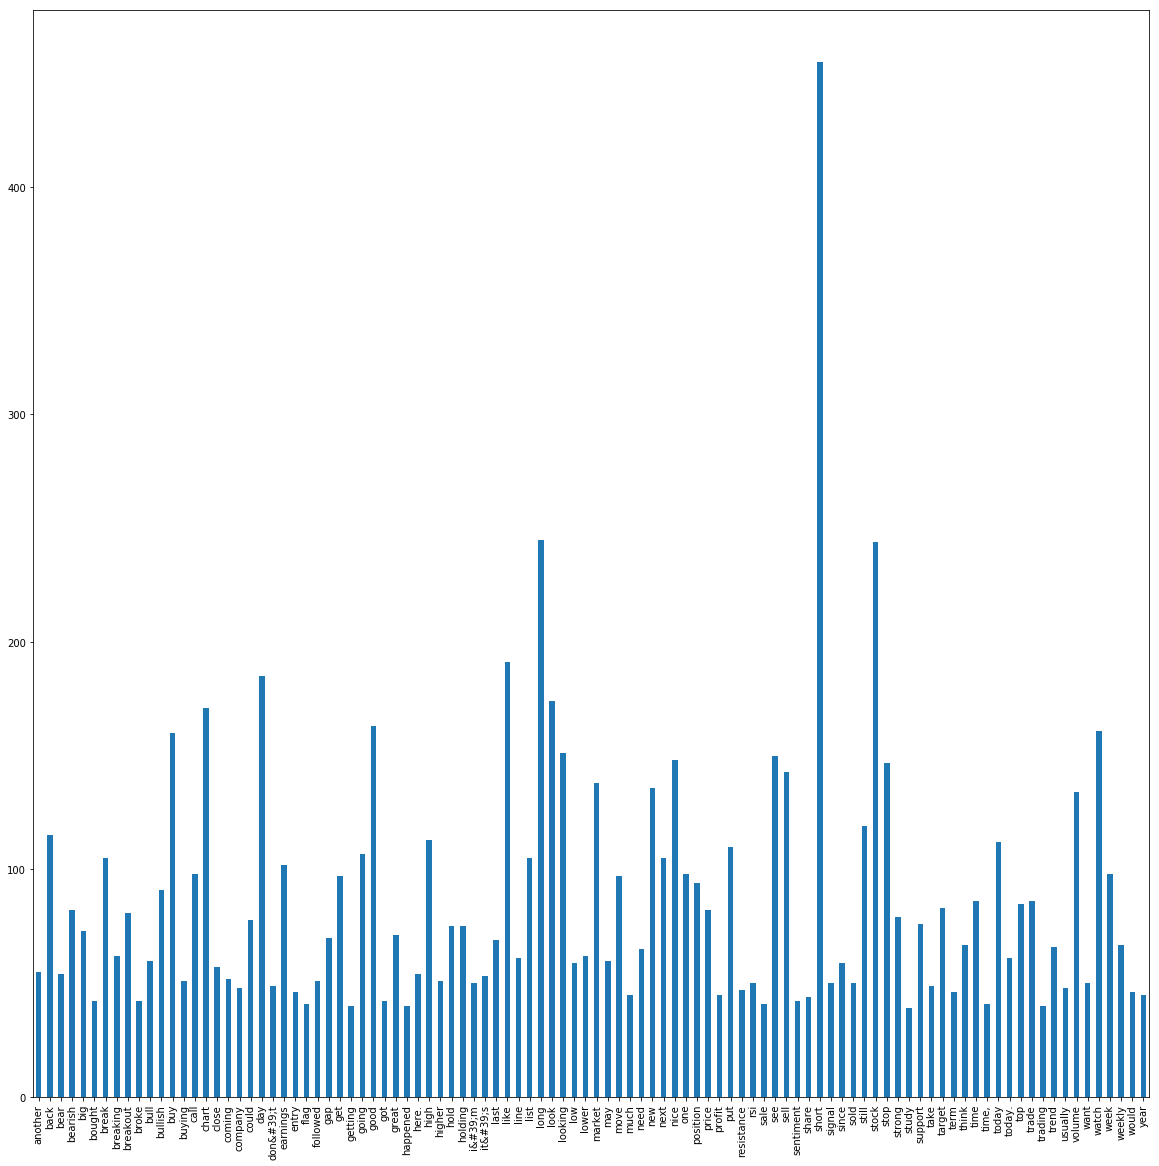

In [13]:
def get_word_frequencies(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    return wordlist

freq_counts = get_word_frequencies(get_words_in_tweets(tweets))
WordFreqs = pd.DataFrame(freq_counts.items())
freq_counts = dict(sorted(freq_counts.iteritems(), key=operator.itemgetter(1), reverse=True)[:100])
freq_counts = pd.Series(freq_counts, name='DateValue')
freq_counts.plot(kind='bar', figsize=(20,20))

#### Writing Word Frequency counts to a CSV

In [14]:
WordFreqs.to_csv('WordFreq.csv', sep=',', encoding='utf-8')

#### Number of Tokens Identified 

In [15]:
print("TOTAL NO. OF TOKEN IDENTIFIED: {}".format(len(w_features)))

TOTAL NO. OF TOKEN IDENTIFIED: 8396


### Naïve-Bayes
Implmenting **Naïve-Bayes** algorithm and training it on Tweets available in the training set i.e. **4500** Tweets. We pass the algorithm a **feature map** for various Tweets. This feature map basically tells, which word is present in a Tweet. Reason for passing input in this form - **Naïve-Bayes expects the caller to specify the feature map. If we don't do that, it would return expection.**

for this process we're using **Multinomial Naïve-Bayes**. But only allows binary features. Further details can be found at http://www.nltk.org/_modules/nltk/classify/naivebayes.html

#### Training the classifier

In [16]:
# Naïve Bayes takes training data in the form of feature vectors. Each feature vector has dimension 
# i.e. (feature_map_size x 1). Against each feature is a boolean values specifying if a certain words 
# from feature map is present in the current Tweet
training_set = nltk.classify.apply_features(extract_features, tweets)

# Training the Naïve Bayes classifier. Using Multinomial Naïve Bayes technique
classifier = nltk.NaiveBayesClassifier.train(training_set)

#### Useful Features identified by Naive Bayes 

In [47]:
print("TOP 10 MOST USEFUL FEATURES IN THIS DATASET\n")
museful = map(lambda X: X[0].split('(')[1].split(')')[0], classifier.most_informative_features(10))
for m in museful:
    print(m)

TOP 10 MOST USEFUL FEATURES IN THIS DATASET

bearish
cup
short
breakout
downside
wkly
triangle
setups:
shorting
short.


**Testing the performance on validation data.** 
While validating the performance of the algorithm, we have also provided an option to set the sample-size to validate on. Reason: Model is trained on a machine with somewhat slow processor. Using all the calidation set would take sometime to show results. Switching to a better system might increase the executiong time.  

In [91]:
sample_size = 100 # total records in validation set = 500
results = predicitions(validation[:sample_size])

y_actual_V = list(zip(*results))[0]
y_pred_V = list(zip(*results))[1]
y_actual_V = [1 if x == "Bullish" else 0 for x in y_actual_V]
y_pred_V = [1 if x == "Bullish" else 0 for x in y_pred_V]

#### Calculating Accuracy of the trained model. The model is able to classify the Tweet with an accuracy of 73%. The reason for a low accuracy can be any of the following (perhaps all):
    1. Limited training data.
    2. Using a Naive approach. Switching to a rather complex algorthim, such as: an RNN should certainly boost     up the correctness of the model.

In [92]:
acc = (sum([x==y for (x,y) in zip(y_actual_V, y_pred_V)]) / float(validation[:sample_size].shape[0])) * 100
print("Accuracy (ON VALIDATION DATA): {}".format(acc))

Accuracy (ON VALIDATION DATA): 79.0


### Predicting on TEST data

In [19]:
# reading .xlsx file in a DataFrame
xl = pd.ExcelFile('Testing Data.xlt')
xl.sheet_names

# Excel file contains data in form of Sheets. Our file contains data in 'Sheet1'
test = xl.parse("user")

# removing unnecessary columns from the DataFrame
test.drop([u'tweet_id', u'user_id', u'permno'], axis=1, inplace=True)

In [20]:
def test_predicitions(test):
    results = []
    for obj in test.values:
        tokens = clean_row(obj[0])
        results.append((tokens, classifier.classify(extract_features(tokens))))
    return results

In [25]:
starting_point = 1956
sample_size = 100 # total records in validation set = 10000
results = test_predicitions(test[starting_point:starting_point+sample_size])

In [33]:
y_pred = list(zip(*results))[1]
y_pred = ['Positive' if x == "Bullish" else 'Negative' for x in y_pred]

In [86]:
print("======= TEST DATA EVALUATION =======\n")
print("% of Tweets classified POSITIVE: {}".format((y_pred.count('Positive') / float(sample_size))*100.0))
print("% of Tweets classified NEGATIVE: {}".format((y_pred.count('Negative') / float(sample_size))*100.0))

======= TEST DATA EVALUATION =======

% of Tweets classified POSITIVE: 57.0
% of Tweets classified NEGATIVE: 43.0


### LM Corpus

In [70]:
with open('LM_Positive.txt') as f:
    LM_Positive = f.read().splitlines()
    
with open('LM_Negative.txt') as f:
    LM_Negative = f.read().splitlines()
    
with open('LM_Uncertain.txt') as f:
    LM_Neutral = f.read().splitlines()
    
LM_Positive = map(str.lower, LM_Positive)
LM_Negative = map(str.lower, LM_Negative)
LM_Neutral = map(str.lower, LM_Neutral)

#### Sentiment Analysis

In [74]:
def classify(tweet):
    sent_p = set(tweet).intersection(LM_Positive)
    sent_n = set(tweet).intersection(LM_Negative)
    sent_u = set(tweet).intersection(LM_Neutral)
    
    sents = ('Neutral', 'Positive', 'Negative')
    result = np.argmax(np.array([sent_n, sent_u, sent_p]))
    return sents[result]
y_cal_LM = map(classify, tokens)

In [89]:
print("======= LM CORPUS EVALUATION =======\n")
print("% of Tweets classified POSITIVE: {}".format((y_cal_LM.count('Positive') / float(len(tokens)))*100.0))
print("% of Tweets classified NEGATIVE: {}".format((y_cal_LM.count('Negative') / float(len(tokens)))*100.0))
print("% of Tweets classified NEUTRAL: {}".format((y_cal_LM.count('Neutral') / float(len(tokens)))*100.0))

======= LM CORPUS EVALUATION =======

% of Tweets classified POSITIVE: 6.49819494585
% of Tweets classified NEGATIVE: 8.25167612171
% of Tweets classified NEUTRAL: 85.2501289324


### Plotting the ROC Curve

ROC curve illustrates varifies the discrimination threshold of Multinomial Naive Bayes (binary classifier). It exhibits a positive relation to cost analysis.

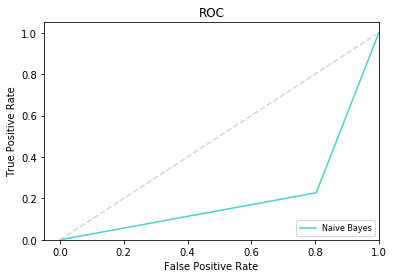

In [93]:
# Find and plot AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_actual_V, y_pred_V, pos_label=0)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Get different color each graph line
color = ["mediumturquoise", "orange"]

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c=color[0], label=('Naive Bayes'))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()